<h1>Decision Tree Implementation</h1><br>
<p>
    <ul>
        <li>I have created the actual decision tree itself. I did not do "creating the decision tree" and "printing as in the given example" separately. I created the decision tree and fitted it with the iris dataset and printed the score too.</li>
        <li>The score is based on the mean accuracy</li>
    </ul>
</p>

In [13]:
import numpy as np
import pandas as pd
import math
from sklearn import datasets

In [14]:
iris = datasets.load_iris()

In [15]:
df = pd.DataFrame(iris.data)
df.columns = ["sl", "sw", 'pl', 'pw']

In [16]:
#Function to find label for a value
#if MIN_Value <=val < (m + Mean_Value) / 2 then it is assigned label a
#if (m + Mean_Value) <=val < Mean_Value then it is assigned label b
#if (Mean_Value) <=val < (Mean_Value + MAX_Value)/2 then it is assigned label c
#if (Mean_Value + MAX_Value)/2 <=val <= MAX_Value  then it is assigned label d

def label(val, *boundaries):
    if (val < boundaries[0]):
        return 'a'
    elif (val < boundaries[1]):
        return 'b'
    elif (val < boundaries[2]):
        return 'c'
    else:
        return 'd'

#Function to convert a continuous data into labelled data
#There are 4 lables  - a, b, c, d
def toLabel(df, old_feature_name):
    second = df[old_feature_name].mean()
    minimum = df[old_feature_name].min()
    first = (minimum + second)/2
    maximum = df[old_feature_name].max()
    third = (maximum + second)/2
    return df[old_feature_name].apply(label, args= (first, second, third))

In [17]:
#Convert all columns to labelled data
df['sl_labeled'] = toLabel(df, 'sl')
df['sw_labeled'] = toLabel(df, 'sw')
df['pl_labeled'] = toLabel(df, 'pl')
df['pw_labeled'] = toLabel(df, 'pw')
df

,sl,sw,pl,pw,sl_labeled,sw_labeled,pl_labeled,pw_labeled
0,5.1,3.5,1.4,0.2,b,c,a,a
1,4.9,3.0,1.4,0.2,a,b,a,a
2,4.7,3.2,1.3,0.2,a,c,a,a
3,4.6,3.1,1.5,0.2,a,c,a,a
4,5.0,3.6,1.4,0.2,a,c,a,a
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,c,b,c,d
146,6.3,2.5,5.0,1.9,c,a,c,d
147,6.5,3.0,5.2,2.0,c,b,c,d
148,6.2,3.4,5.4,2.3,c,c,d,d


In [18]:
df.drop(['sl', 'sw', 'pl', 'pw'], axis = 1, inplace = True)
set(df['sl_labeled'])

{'a', 'b', 'c', 'd'}

In [19]:
class TreeNode:
    def __init__(self, data,output):
        # data is the feature upon which the node is going to split when fitting the training data and it is none for leaf node.
        self.data = data
        # i am storing the children of a node as a dictionary where key = value of feature upon which the node has splitted
        # and the corresponding value stores the child TreeNode
        self.children = {} #dictionary as mentioned above
        # output represents the class with current majority at this instance of the decision tree
        self.output = output
        # "index" variable assigns a perticular index to each node
        self.index = -1
        
    def add_child(self,feature_value,object):
        self.children[feature_value] = object

In [20]:
class build_tree:
    def __init__(self):
        # root node of our decision tree
        self.__root = None

    def __frequency_counter(self,Y):
        # returns a dictionary with keys as unique values of Y(i.e no of classes) and the corresponding value as its frequency
        d = {}
        for i in Y:
            if i in d:
                d[i]+=1
            else:
                d[i]=1
        return d


    def __entropy(self,Y):
        # returns the entropy of that perticular node.
        freq_map = self.__frequency_counter(Y)
        entropy_ = 0
        total = len(Y)
        for i in freq_map:
            p = freq_map[i]/total
            entropy_ += (-p)*math.log2(p)
            #note that i have used log2 and not log10.
        return entropy_

    def __gain_ratio(self,X,Y,selected_feature):
        # returns the gain ratio
        original = self.__entropy(Y) # "original" represents entropy before splitting
        entropy_after_splitting = 0 
        split_info = 0
        values = set(X[:,selected_feature])
        df = pd.DataFrame(X)
        # Appending Y values as the last column in the newely created dataframe 
        df[df.shape[1]] = Y
        starting_size = df.shape[0] 
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            entropy_after_splitting += (current_size/starting_size)*self.__entropy(df1[df1.shape[1]-1])
            split_info += (-current_size/starting_size)*math.log2(current_size/starting_size)

        # when split info is zero, it will give an error. to handle that we have following piece of code
        if split_info == 0 :
            return math.inf 
        #returning negative infinity when split info is 0

        info_gain = original - entropy_after_splitting
        gain_ratio = info_gain / split_info
        return gain_ratio #returned the gain_ratio finally



    def __decision_tree(self,X,Y,features,level,classes, all_features=np.array([i for i in df.columns])):
        # returns the root of the Decision Tree built after fitting the training data
        # classes = all the different classes available to us
        # level = depth of the tree
        # traversal will be in preorder fashion
        
        
        
        #BASE CASES
        # first stopping criteria: If we have run out of features to split upon
        # In this case the answer will be the class whose count is maximum for the given split
        if len(features) == 0:
            print("Level",level)
            freqs = self.__frequency_counter(Y)
            output = None
            max_count = -99999999999999
            for i in classes:
                if i not in freqs:
                    print("Count of",i,"=",0)
                else :
                    if freqs[i] > max_count :
                        output = i
                        max_count = freqs[i]
                    print("Count of",i,"=",freqs[i])

            print("Current Entropy  is =",self.__entropy(Y))          

            print("Reached leaf Node")
            print()
            return TreeNode(None,output)
        
        
        # second stopping criteria: If the node consists of a single pure class
        if len(set(Y)) == 1:
            print("Level",level)
            output = None
            for class_ in classes:
                if class_ in Y:
                    output = class_
                    print("Count of",class_,"=",len(Y))
                else :
                    print("Count of",class_,"=",0)
            print("Current Entropy is =  0.0")
            print("Reached leaf Node")
            print()
            return TreeNode(None,output)

        #now starts the backbone of our decision tree classifier.
        # after the base cases we have to Find the best feature to split upon
        max_gain = -math.inf
        final_feature = None
        for f in features :
            current_gain = self.__gain_ratio(X,Y,f)

            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f

        print("Level",level)
        freqs = self.__frequency_counter(Y)
        output = None
        max_count = -math.inf

        for class_ in classes:
            if class_ not in freqs:
                print("Count of",class_,"=",0)
            else :
                if freqs[class_] > max_count :
                    output = class_
                    max_count = freqs[class_]
                print("Count of",class_,"=",freqs[class_])
     
        print("Current Entropy is =",self.__entropy(Y))
        print("Splitting on feature" , all_features[final_feature] , "with gain ratio" , max_gain)
        print()
        

            
        unique_values = set(X[:,final_feature]) # unique_values represents the unique values of the feature selected
        df = pd.DataFrame(X)
        # appending y values at the end of the data frame.
        df[df.shape[1]] = Y

        current_node = TreeNode(final_feature,output)

        # removing the selected feature from the list.
        index  = features.index(final_feature)
        features.remove(final_feature)
        for i in unique_values:
            # Creating a new dataframe with value of selected feature = i
            df_new = df[df[final_feature] == i]
            # recursively calling on the splits
            node = self.__decision_tree(df_new.iloc[:,0:df_new.shape[1]-1].values,df_new.iloc[:,df_new.shape[1]-1].values,features,level+1,classes)
            current_node.add_child(i,node)

        # Add the removed feature     
        features.insert(index,final_feature)

        return current_node
    
    def fit(self,X,Y):
        # Fits according to the given training data
        features = [i for i in range(len(X[0]))]
        classes = set(Y)
        level = 0
        self.__root = self.__decision_tree(X,Y,features,level,classes)
        
    def __predict_for_single_point(self,data,node):
        # predicts the class for a given testing point
        # We have reached a leaf node
        if len(node.children) == 0 :
            return node.output

        val = data[node.data] # represents the value of feature on which the split is made       
        if val not in node.children :
            return node.output
        
        # Recursively call on the splits
        return self.__predict_for_single_point(data,node.children[val])

    def predict(self,X):
        # This function returns Y-predicted
        # X is a 2D numpy array
        Y = np.array([0 for i in range(len(X))])
        for i in range(len(X)):
            Y[i] = self.__predict_for_single_point(X[i],self.__root)
        return Y
    
    def score(self,X,Y):
        # this function returns the mean accuracy.
        Y_predicted = self.predict(X)
        counter = 0
        for i in range(len(Y_predicted)):
            if Y_predicted[i] == Y[i]:
                counter+=1
        return counter/len(Y_predicted)
    

In [21]:
from sklearn.model_selection import train_test_split
x=df.values
y = iris.target
x_train, x_test, y_train, y_test=train_test_split(x, y)
unused_features = set(df.columns)
clf=build_tree()
clf.fit(x_train, y_train)
print()
print("Score=", clf.score(x_test, y_test))

Level 0
Count of 0 = 36
Count of 1 = 39
Count of 2 = 37
Current Entropy is = 1.5841606263806214
Splitting on feature pw_labeled with gain ratio 0.7002461037280628

Level 1
Count of 0 = 36
Count of 1 = 0
Count of 2 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 0
Count of 2 = 26
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 31
Count of 2 = 11
Current Entropy is = 0.8296071030882032
Splitting on feature pl_labeled with gain ratio 0.4541238312840075

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 4
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 31
Count of 2 = 7
Current Entropy is = 0.6892019851173655
Splitting on feature sl_labeled with gain ratio 0.13620958235588312

Level 3
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 3
Count of 0 = 0
Count of 1 = 2
Count of 2 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 3
Count of 0

In [22]:
# accuracy seems pretty good. you can test it on various datasets be converting 
# the x and y values to the numpy arrays.

NotFittedError: This build_tree instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

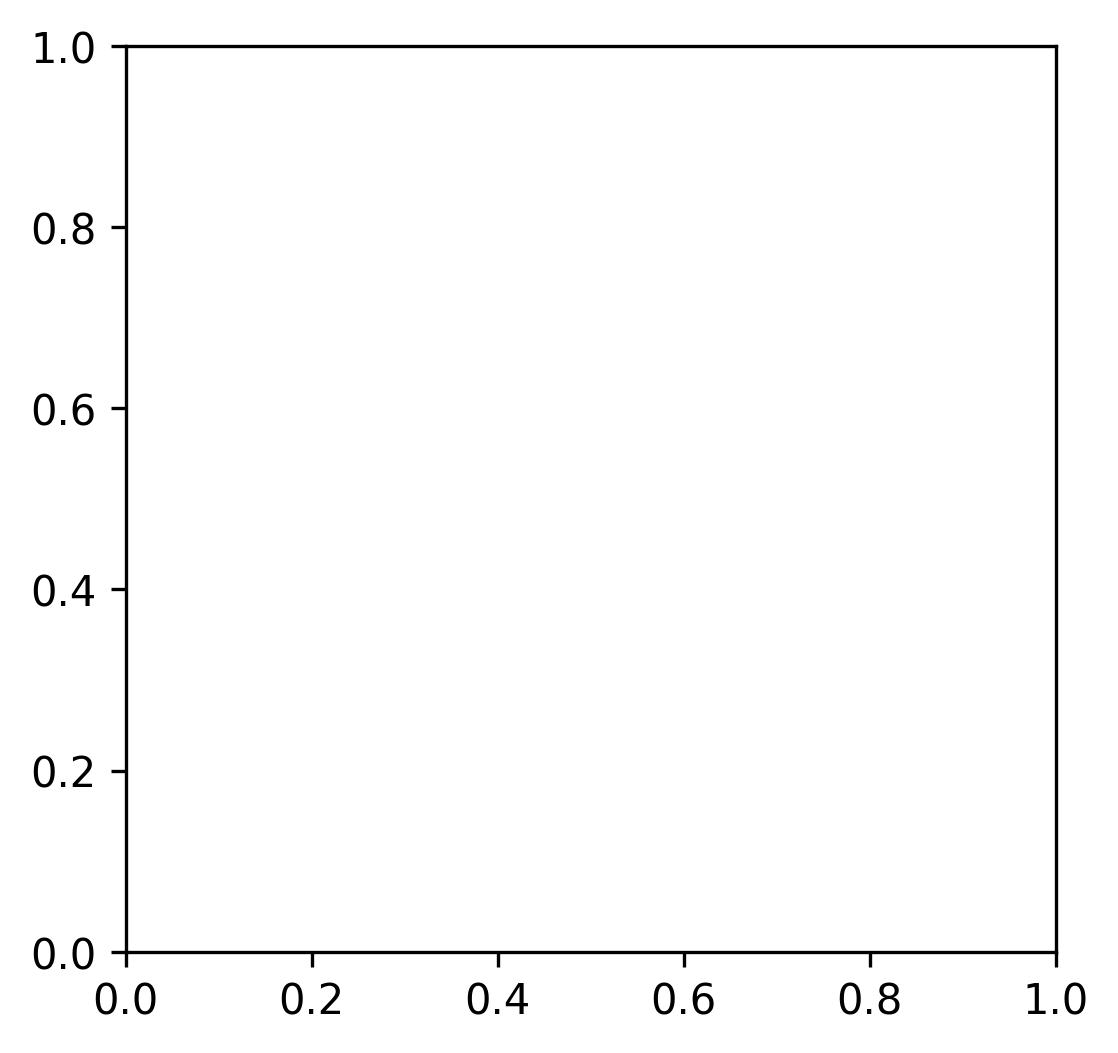

In [23]:
from sklearn import tree
import matplotlib.pyplot as plt

fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('iris.png')